In [1]:
#train01: try to replicate the same condition of UNet0's unet1.ipynb
#That is, dice loss with batch calculation, smooth =1
# import system libs
import os
from glob import glob

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from lg2unetr import SwinUNETR
from monai.losses import DiceLoss
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import cv2
# import pandas as pd
# import numpy as np
import sys
sys.path.append('../Unet0')
from utils import  create_dataloader, dice_coef, iou_coef
from torch.utils.tensorboard import SummaryWriter
# import data handling tools
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# %matplotlib inline
# from skimage.color import rgb2gray
# from skimage.morphology import label
# from skimage.transform import resize
# from skimage.io import imread, imshow, concatenate_images
# sns.set_style('darkgrid')

%reload_ext autoreload
%autoreload 2

/home/vscode/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
def create_df(data_dir):
    images_paths = []
    masks_paths = sorted(glob(f'{data_dir}/*/*_mask*'))

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
data_dir = '/workspaces/data/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

In [4]:
len(train_df), len(valid_df), len(test_df)

(3143, 393, 393)

In [5]:
# %load_ext autoreload
# %autoreload 2
#from utils import create_dataloader
BATCH_SIZE = 8
train_loader = create_dataloader(train_df, batch_size=BATCH_SIZE, augment=True, num_workers=16)
valid_loader = create_dataloader(valid_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)
test_loader = create_dataloader(test_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)


/home/vscode/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


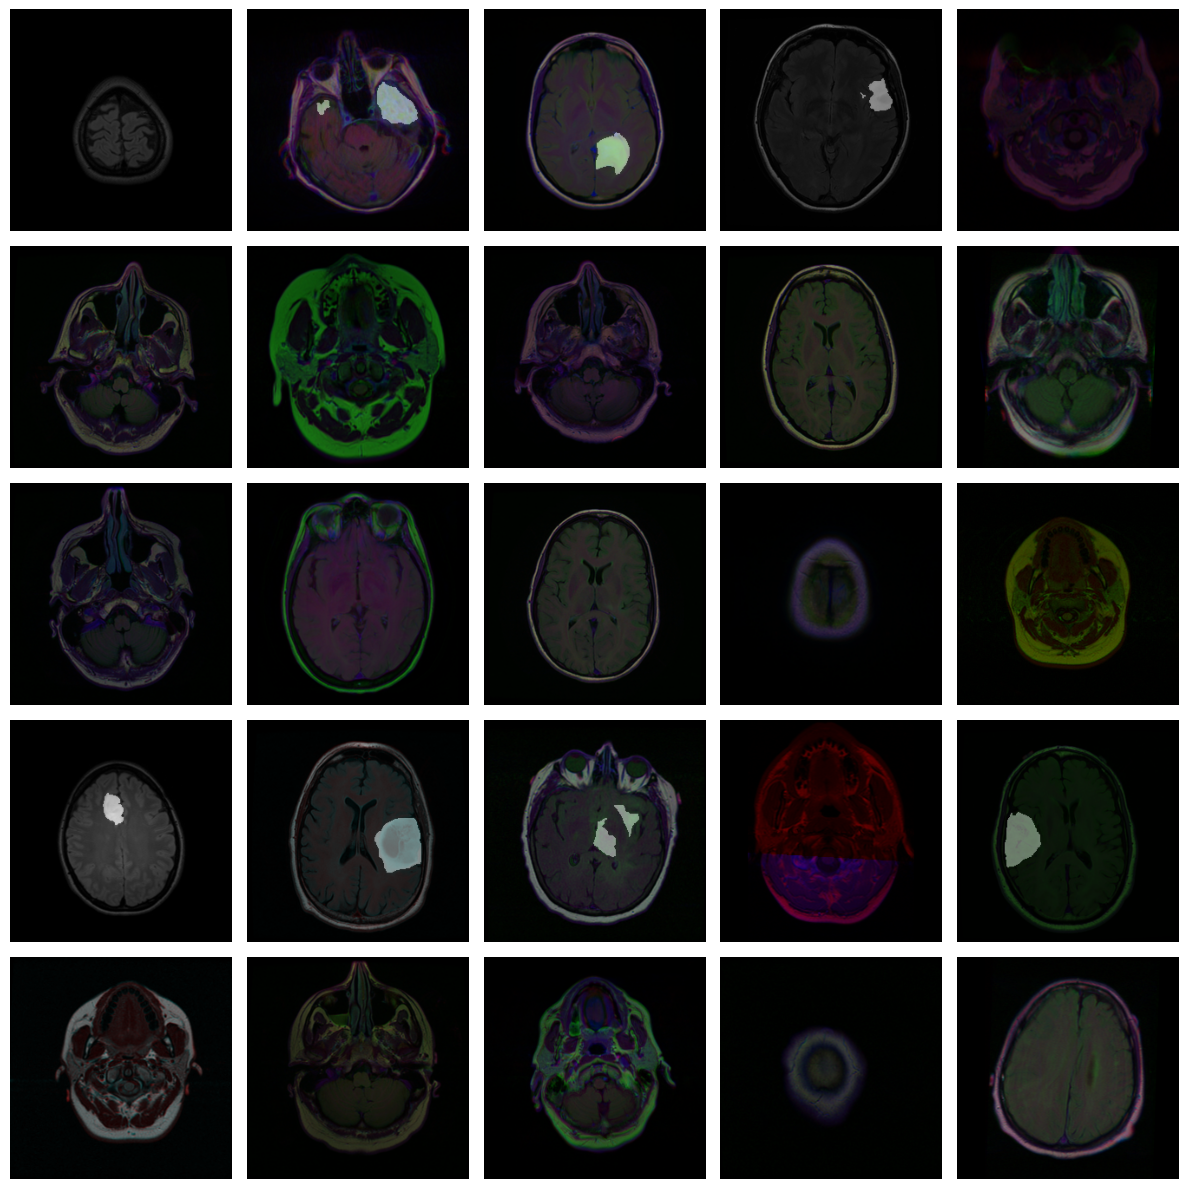

In [6]:
from utils import show_images
show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = UNet(in_channels=3, out_channels=1).to(device)
model = SwinUNETR(
        img_size=(256,256),
        in_channels=3,
        out_channels=1,
        feature_size=24,
        use_checkpoint=False,
        spatial_dims=2
    ).to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001)
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True, batch=True, smooth_nr=1.0, smooth_dr=1.0)
criterion = dice_loss  # al

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    for images, masks in tqdm(dataloader, desc='Training'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)#round2: should be sigmoid activation
        # outputs = torch.sigmoid(outputs)  ## Not needed
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coef(masks,torch.sigmoid(outputs),smooth=1).item()
        total_iou += iou_coef(masks, torch.sigmoid(outputs),smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n



def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validating'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion( outputs, masks)
            total_loss += loss.item()
            total_dice += dice_coef(masks, torch.sigmoid(outputs),smooth=1).item()
            total_iou += iou_coef(masks, torch.sigmoid(outputs),smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n


In [8]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
SwinUNETR                                               [8, 1, 256, 256]          --
├─SwinTransformer: 1-1                                  [8, 24, 128, 128]         --
│    └─PatchEmbed: 2-1                                  [8, 24, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [8, 24, 128, 128]         312
│    └─Dropout: 2-2                                     [8, 24, 128, 128]         --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─BasicLayer: 3-2                             [8, 48, 64, 64]           20,598
│    └─ModuleList: 2-4                                  --                        --
│    │    └─BasicLayer: 3-3                             [8, 96, 32, 32]           137,304
│    └─ModuleList: 2-5                                  --                        --
│    │    └─BasicLayer: 3-4                       

In [9]:
# import os
import datetime

epochs = 120
best_val_loss = float('inf')
save_path = 'LG2-01.pth'

log_dir = os.path.join("/workspaces/data/MegaGen/UNet", 
                       "unet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
}



In [10]:
print ("device:",next(model.parameters()).device)
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_dice, val_iou = validate(model, valid_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    # Log to TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Dice/Train", train_dice, epoch)
    writer.add_scalar("Dice/Val", val_dice, epoch)
    writer.add_scalar("IoU/Train", train_iou, epoch)
    writer.add_scalar("IoU/Val", val_iou, epoch)

    # Save to history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)


device: cuda:0

Epoch 1/120


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Validating: 100%|██████████| 50/50 [00:04<00:00, 10.97it/s]


Train Loss: 0.8870, Dice: 0.1130, IoU: 0.0627
Val   Loss: 0.7325, Dice: 0.2675, IoU: 0.1599
Validation loss improved (inf → 0.7325). Saving model...

Epoch 2/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.65it/s]


Train Loss: 0.5024, Dice: 0.4976, IoU: 0.3580
Val   Loss: 0.3600, Dice: 0.6400, IoU: 0.5051
Validation loss improved (0.7325 → 0.3600). Saving model...

Epoch 3/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.55it/s]


Train Loss: 0.3321, Dice: 0.6679, IoU: 0.5336
Val   Loss: 0.2970, Dice: 0.7030, IoU: 0.5730
Validation loss improved (0.3600 → 0.2970). Saving model...

Epoch 4/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.58it/s]


Train Loss: 0.2907, Dice: 0.7093, IoU: 0.5803
Val   Loss: 0.2292, Dice: 0.7708, IoU: 0.6534
Validation loss improved (0.2970 → 0.2292). Saving model...

Epoch 5/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


Train Loss: 0.2695, Dice: 0.7305, IoU: 0.6074
Val   Loss: 0.2518, Dice: 0.7482, IoU: 0.6301

Epoch 6/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.55it/s]


Train Loss: 0.2587, Dice: 0.7413, IoU: 0.6243
Val   Loss: 0.2837, Dice: 0.7163, IoU: 0.6079

Epoch 7/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


Train Loss: 0.2533, Dice: 0.7467, IoU: 0.6322
Val   Loss: 0.2633, Dice: 0.7367, IoU: 0.6276

Epoch 8/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Train Loss: 0.2532, Dice: 0.7468, IoU: 0.6323
Val   Loss: 0.2441, Dice: 0.7559, IoU: 0.6484

Epoch 9/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]


Train Loss: 0.2353, Dice: 0.7647, IoU: 0.6553
Val   Loss: 0.2580, Dice: 0.7420, IoU: 0.6358

Epoch 10/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.43it/s]


Train Loss: 0.2272, Dice: 0.7728, IoU: 0.6618
Val   Loss: 0.2497, Dice: 0.7503, IoU: 0.6384

Epoch 11/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


Train Loss: 0.2206, Dice: 0.7794, IoU: 0.6683
Val   Loss: 0.2327, Dice: 0.7673, IoU: 0.6628

Epoch 12/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]


Train Loss: 0.2180, Dice: 0.7820, IoU: 0.6734
Val   Loss: 0.1912, Dice: 0.8088, IoU: 0.7017
Validation loss improved (0.2292 → 0.1912). Saving model...

Epoch 13/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Train Loss: 0.2174, Dice: 0.7826, IoU: 0.6787
Val   Loss: 0.2187, Dice: 0.7813, IoU: 0.6747

Epoch 14/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.57it/s]


Train Loss: 0.2152, Dice: 0.7848, IoU: 0.6768
Val   Loss: 0.2583, Dice: 0.7417, IoU: 0.6413

Epoch 15/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


Train Loss: 0.2083, Dice: 0.7917, IoU: 0.6868
Val   Loss: 0.2438, Dice: 0.7562, IoU: 0.6543

Epoch 16/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


Train Loss: 0.2043, Dice: 0.7957, IoU: 0.6903
Val   Loss: 0.1901, Dice: 0.8099, IoU: 0.7052
Validation loss improved (0.1912 → 0.1901). Saving model...

Epoch 17/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.48it/s]


Train Loss: 0.1910, Dice: 0.8090, IoU: 0.7055
Val   Loss: 0.2149, Dice: 0.7851, IoU: 0.6818

Epoch 18/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Train Loss: 0.2209, Dice: 0.7791, IoU: 0.6768
Val   Loss: 0.1863, Dice: 0.8137, IoU: 0.7095
Validation loss improved (0.1901 → 0.1863). Saving model...

Epoch 19/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Train Loss: 0.1902, Dice: 0.8098, IoU: 0.7110
Val   Loss: 0.2354, Dice: 0.7646, IoU: 0.6629

Epoch 20/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


Train Loss: 0.1817, Dice: 0.8183, IoU: 0.7199
Val   Loss: 0.1650, Dice: 0.8350, IoU: 0.7362
Validation loss improved (0.1863 → 0.1650). Saving model...

Epoch 21/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]


Train Loss: 0.1896, Dice: 0.8104, IoU: 0.7109
Val   Loss: 0.2059, Dice: 0.7941, IoU: 0.6934

Epoch 22/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


Train Loss: 0.1776, Dice: 0.8224, IoU: 0.7238
Val   Loss: 0.2055, Dice: 0.7945, IoU: 0.6944

Epoch 23/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Train Loss: 0.2009, Dice: 0.7991, IoU: 0.7007
Val   Loss: 0.2204, Dice: 0.7796, IoU: 0.6845

Epoch 24/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.43it/s]


Train Loss: 0.1719, Dice: 0.8281, IoU: 0.7317
Val   Loss: 0.1631, Dice: 0.8369, IoU: 0.7416
Validation loss improved (0.1650 → 0.1631). Saving model...

Epoch 25/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


Train Loss: 0.1871, Dice: 0.8129, IoU: 0.7182
Val   Loss: 0.1728, Dice: 0.8272, IoU: 0.7256

Epoch 26/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


Train Loss: 0.1827, Dice: 0.8173, IoU: 0.7175
Val   Loss: 0.1918, Dice: 0.8082, IoU: 0.7162

Epoch 27/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]


Train Loss: 0.1770, Dice: 0.8230, IoU: 0.7239
Val   Loss: 0.2003, Dice: 0.7997, IoU: 0.7048

Epoch 28/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


Train Loss: 0.1906, Dice: 0.8094, IoU: 0.7122
Val   Loss: 0.1585, Dice: 0.8415, IoU: 0.7449
Validation loss improved (0.1631 → 0.1585). Saving model...

Epoch 29/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Train Loss: 0.1624, Dice: 0.8376, IoU: 0.7445
Val   Loss: 0.1596, Dice: 0.8404, IoU: 0.7429

Epoch 30/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


Train Loss: 0.1962, Dice: 0.8038, IoU: 0.7108
Val   Loss: 0.2565, Dice: 0.7435, IoU: 0.6383

Epoch 31/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Train Loss: 0.1785, Dice: 0.8215, IoU: 0.7265
Val   Loss: 0.1576, Dice: 0.8424, IoU: 0.7469
Validation loss improved (0.1585 → 0.1576). Saving model...

Epoch 32/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.53it/s]


Train Loss: 0.1778, Dice: 0.8222, IoU: 0.7304
Val   Loss: 0.1535, Dice: 0.8465, IoU: 0.7525
Validation loss improved (0.1576 → 0.1535). Saving model...

Epoch 33/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


Train Loss: 0.1634, Dice: 0.8366, IoU: 0.7448
Val   Loss: 0.2146, Dice: 0.7854, IoU: 0.6965

Epoch 34/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.08it/s]


Train Loss: 0.1732, Dice: 0.8268, IoU: 0.7318
Val   Loss: 0.1941, Dice: 0.8059, IoU: 0.7075

Epoch 35/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


Train Loss: 0.1870, Dice: 0.8130, IoU: 0.7180
Val   Loss: 0.1587, Dice: 0.8413, IoU: 0.7463

Epoch 36/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


Train Loss: 0.1698, Dice: 0.8302, IoU: 0.7368
Val   Loss: 0.1624, Dice: 0.8376, IoU: 0.7385

Epoch 37/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


Train Loss: 0.1552, Dice: 0.8448, IoU: 0.7527
Val   Loss: 0.1772, Dice: 0.8228, IoU: 0.7309

Epoch 38/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.97it/s]


Train Loss: 0.1570, Dice: 0.8430, IoU: 0.7505
Val   Loss: 0.1551, Dice: 0.8449, IoU: 0.7431

Epoch 39/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


Train Loss: 0.1614, Dice: 0.8386, IoU: 0.7473
Val   Loss: 0.1637, Dice: 0.8363, IoU: 0.7392

Epoch 40/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


Train Loss: 0.1620, Dice: 0.8380, IoU: 0.7458
Val   Loss: 0.1690, Dice: 0.8310, IoU: 0.7348

Epoch 41/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


Train Loss: 0.1571, Dice: 0.8429, IoU: 0.7533
Val   Loss: 0.1305, Dice: 0.8695, IoU: 0.7801
Validation loss improved (0.1535 → 0.1305). Saving model...

Epoch 42/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Train Loss: 0.1415, Dice: 0.8585, IoU: 0.7709
Val   Loss: 0.1794, Dice: 0.8206, IoU: 0.7259

Epoch 43/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


Train Loss: 0.1593, Dice: 0.8407, IoU: 0.7529
Val   Loss: 0.1631, Dice: 0.8369, IoU: 0.7501

Epoch 44/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.42it/s]


Train Loss: 0.1620, Dice: 0.8380, IoU: 0.7476
Val   Loss: 0.1608, Dice: 0.8392, IoU: 0.7400

Epoch 45/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


Train Loss: 0.1512, Dice: 0.8488, IoU: 0.7593
Val   Loss: 0.1399, Dice: 0.8601, IoU: 0.7649

Epoch 46/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


Train Loss: 0.1518, Dice: 0.8482, IoU: 0.7572
Val   Loss: 0.2173, Dice: 0.7827, IoU: 0.6862

Epoch 47/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.49it/s]


Train Loss: 0.1483, Dice: 0.8517, IoU: 0.7624
Val   Loss: 0.1623, Dice: 0.8377, IoU: 0.7501

Epoch 48/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]


Train Loss: 0.1578, Dice: 0.8422, IoU: 0.7547
Val   Loss: 0.1469, Dice: 0.8531, IoU: 0.7629

Epoch 49/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


Train Loss: 0.1702, Dice: 0.8298, IoU: 0.7368
Val   Loss: 0.1492, Dice: 0.8508, IoU: 0.7549

Epoch 50/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


Train Loss: 0.1476, Dice: 0.8524, IoU: 0.7632
Val   Loss: 0.1773, Dice: 0.8227, IoU: 0.7273

Epoch 51/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]


Train Loss: 0.1517, Dice: 0.8483, IoU: 0.7590
Val   Loss: 0.1585, Dice: 0.8415, IoU: 0.7450

Epoch 52/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


Train Loss: 0.1554, Dice: 0.8446, IoU: 0.7527
Val   Loss: 0.1431, Dice: 0.8569, IoU: 0.7630

Epoch 53/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]


Train Loss: 0.1453, Dice: 0.8547, IoU: 0.7649
Val   Loss: 0.1357, Dice: 0.8643, IoU: 0.7710

Epoch 54/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.78it/s]


Train Loss: 0.1431, Dice: 0.8569, IoU: 0.7697
Val   Loss: 0.1537, Dice: 0.8463, IoU: 0.7561

Epoch 55/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


Train Loss: 0.1492, Dice: 0.8508, IoU: 0.7622
Val   Loss: 0.1456, Dice: 0.8544, IoU: 0.7662

Epoch 56/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Train Loss: 0.1511, Dice: 0.8489, IoU: 0.7612
Val   Loss: 0.1519, Dice: 0.8481, IoU: 0.7569

Epoch 57/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Train Loss: 0.1428, Dice: 0.8572, IoU: 0.7687
Val   Loss: 0.1932, Dice: 0.8068, IoU: 0.7113

Epoch 58/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.05it/s]


Train Loss: 0.1542, Dice: 0.8458, IoU: 0.7548
Val   Loss: 0.1582, Dice: 0.8418, IoU: 0.7453

Epoch 59/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.31it/s]


Train Loss: 0.1563, Dice: 0.8437, IoU: 0.7553
Val   Loss: 0.1786, Dice: 0.8214, IoU: 0.7330

Epoch 60/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Train Loss: 0.1581, Dice: 0.8419, IoU: 0.7537
Val   Loss: 0.1786, Dice: 0.8214, IoU: 0.7295

Epoch 61/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Train Loss: 0.1471, Dice: 0.8529, IoU: 0.7652
Val   Loss: 0.1774, Dice: 0.8226, IoU: 0.7277

Epoch 62/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Train Loss: 0.1437, Dice: 0.8563, IoU: 0.7662
Val   Loss: 0.1758, Dice: 0.8242, IoU: 0.7392

Epoch 63/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]


Train Loss: 0.1473, Dice: 0.8527, IoU: 0.7653
Val   Loss: 0.1672, Dice: 0.8328, IoU: 0.7410

Epoch 64/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


Train Loss: 0.1445, Dice: 0.8555, IoU: 0.7659
Val   Loss: 0.1544, Dice: 0.8456, IoU: 0.7517

Epoch 65/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


Train Loss: 0.1662, Dice: 0.8338, IoU: 0.7431
Val   Loss: 0.1513, Dice: 0.8487, IoU: 0.7472

Epoch 66/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.42it/s]


Train Loss: 0.1656, Dice: 0.8344, IoU: 0.7408
Val   Loss: 0.1565, Dice: 0.8435, IoU: 0.7493

Epoch 67/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.10it/s]


Train Loss: 0.1463, Dice: 0.8537, IoU: 0.7646
Val   Loss: 0.1369, Dice: 0.8631, IoU: 0.7730

Epoch 68/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.17it/s]


Train Loss: 0.1676, Dice: 0.8324, IoU: 0.7407
Val   Loss: 0.1618, Dice: 0.8382, IoU: 0.7522

Epoch 69/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.96it/s]


Train Loss: 0.1517, Dice: 0.8483, IoU: 0.7581
Val   Loss: 0.1492, Dice: 0.8508, IoU: 0.7594

Epoch 70/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.99it/s]


Train Loss: 0.1540, Dice: 0.8460, IoU: 0.7535
Val   Loss: 0.2333, Dice: 0.7667, IoU: 0.6802

Epoch 71/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


Train Loss: 0.1567, Dice: 0.8433, IoU: 0.7544
Val   Loss: 0.1498, Dice: 0.8502, IoU: 0.7562

Epoch 72/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


Train Loss: 0.1401, Dice: 0.8599, IoU: 0.7725
Val   Loss: 0.1597, Dice: 0.8403, IoU: 0.7436

Epoch 73/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


Train Loss: 0.1381, Dice: 0.8619, IoU: 0.7766
Val   Loss: 0.1676, Dice: 0.8324, IoU: 0.7443

Epoch 74/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


Train Loss: 0.1304, Dice: 0.8696, IoU: 0.7834
Val   Loss: 0.1636, Dice: 0.8364, IoU: 0.7412

Epoch 75/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Train Loss: 0.1403, Dice: 0.8597, IoU: 0.7743
Val   Loss: 0.1472, Dice: 0.8528, IoU: 0.7606

Epoch 76/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


Train Loss: 0.1305, Dice: 0.8695, IoU: 0.7844
Val   Loss: 0.1600, Dice: 0.8400, IoU: 0.7443

Epoch 77/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]


Train Loss: 0.1375, Dice: 0.8625, IoU: 0.7753
Val   Loss: 0.1429, Dice: 0.8571, IoU: 0.7693

Epoch 78/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


Train Loss: 0.1411, Dice: 0.8589, IoU: 0.7699
Val   Loss: 0.1491, Dice: 0.8509, IoU: 0.7549

Epoch 79/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Train Loss: 0.1774, Dice: 0.8226, IoU: 0.7286
Val   Loss: 0.1681, Dice: 0.8319, IoU: 0.7438

Epoch 80/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


Train Loss: 0.1518, Dice: 0.8482, IoU: 0.7623
Val   Loss: 0.1582, Dice: 0.8418, IoU: 0.7460

Epoch 81/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.12it/s]


Train Loss: 0.1524, Dice: 0.8476, IoU: 0.7584
Val   Loss: 0.1654, Dice: 0.8346, IoU: 0.7450

Epoch 82/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.10it/s]


Train Loss: 0.1631, Dice: 0.8369, IoU: 0.7500
Val   Loss: 0.1463, Dice: 0.8537, IoU: 0.7643

Epoch 83/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Train Loss: 0.1586, Dice: 0.8414, IoU: 0.7556
Val   Loss: 0.1402, Dice: 0.8598, IoU: 0.7680

Epoch 84/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


Train Loss: 0.1639, Dice: 0.8361, IoU: 0.7457
Val   Loss: 0.1572, Dice: 0.8428, IoU: 0.7553

Epoch 85/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


Train Loss: 0.1562, Dice: 0.8438, IoU: 0.7554
Val   Loss: 0.1856, Dice: 0.8144, IoU: 0.7221

Epoch 86/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


Train Loss: 0.1463, Dice: 0.8537, IoU: 0.7648
Val   Loss: 0.1777, Dice: 0.8223, IoU: 0.7217

Epoch 87/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


Train Loss: 0.1461, Dice: 0.8539, IoU: 0.7670
Val   Loss: 0.1383, Dice: 0.8617, IoU: 0.7744

Epoch 88/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


Train Loss: 0.1321, Dice: 0.8679, IoU: 0.7804
Val   Loss: 0.1819, Dice: 0.8181, IoU: 0.7230

Epoch 89/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


Train Loss: 0.1353, Dice: 0.8647, IoU: 0.7768
Val   Loss: 0.1723, Dice: 0.8277, IoU: 0.7338

Epoch 90/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Train Loss: 0.1399, Dice: 0.8601, IoU: 0.7717
Val   Loss: 0.1452, Dice: 0.8548, IoU: 0.7700

Epoch 91/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


Train Loss: 0.1373, Dice: 0.8627, IoU: 0.7762
Val   Loss: 0.1330, Dice: 0.8670, IoU: 0.7756

Epoch 92/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


Train Loss: 0.1419, Dice: 0.8581, IoU: 0.7715
Val   Loss: 0.1451, Dice: 0.8549, IoU: 0.7646

Epoch 93/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


Train Loss: 0.1524, Dice: 0.8476, IoU: 0.7604
Val   Loss: 0.1723, Dice: 0.8277, IoU: 0.7322

Epoch 94/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Train Loss: 0.1417, Dice: 0.8583, IoU: 0.7718
Val   Loss: 0.2077, Dice: 0.7923, IoU: 0.6913

Epoch 95/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


Train Loss: 0.1627, Dice: 0.8373, IoU: 0.7477
Val   Loss: 0.1409, Dice: 0.8591, IoU: 0.7698

Epoch 96/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Train Loss: 0.1292, Dice: 0.8708, IoU: 0.7868
Val   Loss: 0.1369, Dice: 0.8631, IoU: 0.7774

Epoch 97/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]


Train Loss: 0.1396, Dice: 0.8604, IoU: 0.7751
Val   Loss: 0.1389, Dice: 0.8611, IoU: 0.7718

Epoch 98/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


Train Loss: 0.1421, Dice: 0.8579, IoU: 0.7694
Val   Loss: 0.1454, Dice: 0.8546, IoU: 0.7602

Epoch 99/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.12it/s]


Train Loss: 0.1492, Dice: 0.8508, IoU: 0.7647
Val   Loss: 0.1578, Dice: 0.8422, IoU: 0.7568

Epoch 100/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


Train Loss: 0.1400, Dice: 0.8600, IoU: 0.7768
Val   Loss: 0.1624, Dice: 0.8376, IoU: 0.7492

Epoch 101/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


Train Loss: 0.1445, Dice: 0.8555, IoU: 0.7703
Val   Loss: 0.1793, Dice: 0.8207, IoU: 0.7345

Epoch 102/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s]


Train Loss: 0.1196, Dice: 0.8804, IoU: 0.8003
Val   Loss: 0.1573, Dice: 0.8427, IoU: 0.7473

Epoch 103/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Train Loss: 0.1291, Dice: 0.8709, IoU: 0.7850
Val   Loss: 0.1323, Dice: 0.8677, IoU: 0.7744

Epoch 104/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.11it/s]


Train Loss: 0.1516, Dice: 0.8484, IoU: 0.7598
Val   Loss: 0.1453, Dice: 0.8547, IoU: 0.7658

Epoch 105/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.20it/s]


Train Loss: 0.1379, Dice: 0.8621, IoU: 0.7748
Val   Loss: 0.1535, Dice: 0.8465, IoU: 0.7564

Epoch 106/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.45it/s]


Train Loss: 0.1401, Dice: 0.8599, IoU: 0.7756
Val   Loss: 0.1548, Dice: 0.8452, IoU: 0.7600

Epoch 107/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Train Loss: 0.1362, Dice: 0.8638, IoU: 0.7766
Val   Loss: 0.1329, Dice: 0.8671, IoU: 0.7767

Epoch 108/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.59it/s]


Train Loss: 0.1429, Dice: 0.8571, IoU: 0.7722
Val   Loss: 0.1347, Dice: 0.8653, IoU: 0.7753

Epoch 109/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.17it/s]


Train Loss: 0.1434, Dice: 0.8566, IoU: 0.7707
Val   Loss: 0.1258, Dice: 0.8742, IoU: 0.7936
Validation loss improved (0.1305 → 0.1258). Saving model...

Epoch 110/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Train Loss: 0.1445, Dice: 0.8555, IoU: 0.7696
Val   Loss: 0.1820, Dice: 0.8180, IoU: 0.7234

Epoch 111/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


Train Loss: 0.1635, Dice: 0.8365, IoU: 0.7499
Val   Loss: 0.1674, Dice: 0.8326, IoU: 0.7443

Epoch 112/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


Train Loss: 0.1297, Dice: 0.8703, IoU: 0.7860
Val   Loss: 0.1557, Dice: 0.8443, IoU: 0.7499

Epoch 113/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]


Train Loss: 0.1418, Dice: 0.8582, IoU: 0.7699
Val   Loss: 0.1247, Dice: 0.8753, IoU: 0.7876
Validation loss improved (0.1258 → 0.1247). Saving model...

Epoch 114/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


Train Loss: 0.1304, Dice: 0.8696, IoU: 0.7854
Val   Loss: 0.1619, Dice: 0.8381, IoU: 0.7463

Epoch 115/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Train Loss: 0.1367, Dice: 0.8633, IoU: 0.7789
Val   Loss: 0.1371, Dice: 0.8629, IoU: 0.7751

Epoch 116/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


Train Loss: 0.1270, Dice: 0.8730, IoU: 0.7928
Val   Loss: 0.1337, Dice: 0.8663, IoU: 0.7813

Epoch 117/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


Train Loss: 0.1345, Dice: 0.8655, IoU: 0.7820
Val   Loss: 0.1623, Dice: 0.8377, IoU: 0.7509

Epoch 118/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


Train Loss: 0.1332, Dice: 0.8668, IoU: 0.7823
Val   Loss: 0.1422, Dice: 0.8578, IoU: 0.7663

Epoch 119/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


Train Loss: 0.1480, Dice: 0.8520, IoU: 0.7673
Val   Loss: 0.1501, Dice: 0.8499, IoU: 0.7511

Epoch 120/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.20it/s]

Train Loss: 0.1479, Dice: 0.8521, IoU: 0.7645
Val   Loss: 0.1429, Dice: 0.8571, IoU: 0.7622


In [11]:
cv2.imread(train_df.iloc[1].images_paths).shape

(256, 256, 3)